#### **This notebook is a simple attempt on how to augment an image dataset. I will be using the [Bengali handwritten digit dataset](https://www.kaggle.com/datasets/wchowdhu/bengali-digits) for augmentation.**

#### Let's get started!

## Introduction

The amount of labeled data available to train a machine learning model might impact the model’s performance. This is especially true in case of deep learning-based models that generally benefit from larger amounts of annotated training examples to be able to distinguish between the different output classes. However it can be an expensive and time-consuming process to manually annotate additional data. Data augmentation can be used to generate synthetic data using the original data we have.

In this tutorial, I show how to use basic transformations on input digit images to increase a training dataset.

## Import the Necessary Libraries

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
from tqdm.notebook import trange
import skimage.io as io
from skimage.transform import rotate, rescale, resize
from skimage.util import random_noise
from skimage import exposure
from skimage.filters import gaussian
from skimage.io import imread, imsave
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Read the Data

Read the data files from the source directory and assign corresponding target labels to the images. The image files and corresponding labels are then loaded into a pandas dataframe.

In [2]:
def read_data(data_dir='../input/bengali-digits/bengali_digits'):
    ''' Read data from source directory '''
    data = []
    labels = []
    for data_type in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
        digit = int(data_type[-1])
        path = os.path.join(data_dir, data_type, '*.jpg')
        files = glob.glob(path)
        for f in files:
            data.append(f)
            labels.append(digit)
    assert len(data) == len(labels), "{}/{} Data size does not match labels size".format(len(data), len(labels))
    return data, labels


source_dir = '../input/bengali-digits/bengali_digits'
data, labels = read_data(source_dir)
assert len(data) == len(labels), "Number of image files do not match number of labels!"

df = pd.DataFrame(list(zip(data, labels)), columns =['file', 'label'])
df.head()

,file,label
0,../input/bengali-digits/bengali_digits/0/1_DHA...,0
1,../input/bengali-digits/bengali_digits/0/1_MAD...,0
2,../input/bengali-digits/bengali_digits/0/1_DHA...,0
3,../input/bengali-digits/bengali_digits/0/1_NOA...,0
4,../input/bengali-digits/bengali_digits/0/1_B.B...,0


## Load and Split the Data

The dataset is split into separate training, validation, and test subsets to train and evaluate the performance of the machine learning model. Stratification is applied to preserve the original distribution of the target classes.

The following preprocessing steps are applied to the input images:

- Resize all the input images to a fixed shape
- Normalize the image tensors to have pixel values scaled down between -1 and 1 from 0 to 255 which helps with faster convergence

In [3]:
def load_data(df):
  ''' Load and process data '''
  all_images = []
  for img_file in tqdm(df['file'].tolist()):
    img = imread(img_file)
    img = img/255.0 # Normalize
    img = resize(img, (28, 28), anti_aliasing=True)
    all_images.append(img)

  x_np = np.stack(all_images, axis=0)
  y_np = df['label'].values
  print('original train data shape', x_np.shape, y_np.shape)
  return x_np, y_np

all_images, all_labels = load_data(df)

all_train_features, test_features, all_train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=123, stratify=all_labels)
train_features, val_features, train_labels, val_labels = train_test_split(all_train_features, all_train_labels, test_size=0.2, random_state=123, stratify=all_train_labels)

print("Total Training Examples in Original Data: {}".format(len(train_features)))
print("Total Validation Examples in Original Data: {}".format(len(val_features)))
print("Total Test Examples in Original Data: {}".format(len(test_features)))

100%|██████████| 15620/15620 [01:47<00:00, 145.72it/s]


original train data shape (15620, 28, 28, 3) (15620,)
Total Training Examples in Original Data: 9996
Total Validation Examples in Original Data: 2500
Total Test Examples in Original Data: 3124


## Apply Data Augmentation 

Data augmentation will only be applied on the training set to increase the number of training samples. Since data consists of digit images, I apply transformations to an input image that will preserve the original digit number. Hence 4 different transformations are applied to each input image:

- Blur the image
- Rotate the image to 25 degrees retaining the digit shape
- Apply noise to the image
- Apply brightness to the image

Python's image processing library, `skimage`, is used to generate the new transformed images.

In [4]:
def augment_data(train_features, train_labels):
  ''' Augment data by applying different transformations '''
  augmented_train_features, augmented_train_labels = [], []
  train_size = len(train_features)
  for i in trange(train_size):
    image = train_features[i]
    augmented_train_features.append(image) #original image
    augmented_train_features.append(gaussian(image, sigma=1, multichannel=True)) #blurred image
    augmented_train_features.append(rotate(image, angle=25, mode='wrap')) #rotated image
    augmented_train_features.append(random_noise(image, var=0.2**2)) #noisy image
    augmented_train_features.append(exposure.adjust_gamma(image, 2)) #dark image
    for j in range(5):
      augmented_train_labels.append(train_labels[i])
  return np.stack(augmented_train_features, axis=0), augmented_train_labels



augmented_train_features, augmented_train_labels = augment_data(train_features, train_labels)
print("Total Training Examples after Augmentation: {}".format(len(augmented_train_features)))

  0%|          | 0/9996 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  


Total Training Examples after Augmentation: 49980


The training set increased from 9,996 examples to 49,980 images. The augmented training dataset has 49,980 images containing different transformations of the original training images.

## Visualize the Applied Transformations to an Input Image

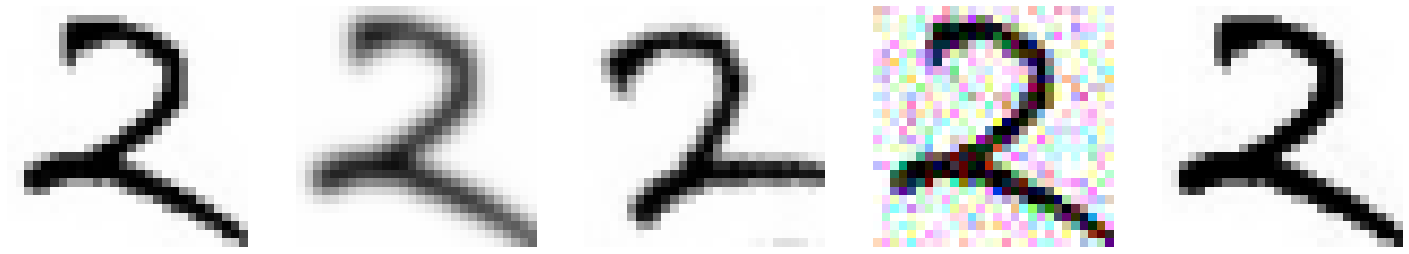

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 25))
for i in range(5):
    ax[i].imshow(augmented_train_features[i])
    ax[i].axis('off')

That's it! This is a small tutorial for beginners to get started on data augmentation for digit images.

For a tutorial on implementing a classification model for Bengali handwritten digit recognition, you can check this [notebook](https://www.kaggle.com/code/wchowdhu/tutorial-on-bengali-digit-classification).



<span style="color:blue">If you found this notebook helpful, please leave your feedback or any suggestions, and kindly upvote. Thanks!</span>